# RAG (Retrieval-Augmented Generation)

## Background 

RAG involves selectively adding relevant information to improve LLM responses while preventing context overload. As Drew notes, this technique is critical even with large context windows because **"Context is not free. Every token in the context influences the model's behavior."**

- RAG prevents information overload by carefully selecting relevant information
- Example implementation: Storing tool descriptions in a vector database for dynamic retrieval
- Essential for maintaining response quality as context grows

## RAG in Practice

[RAG](https://github.com/langchain-ai/rag-from-scratch) (retrieval augmented generation) is an extremely rich topic. Code agents are some of the best examples of agentic RAG in large-scale production. [In practice, RAG is can be a central context engineering challenge](https://x.com/_mohansolo/status/1899630246862966837). Varun from Windsurf captures some of these challenges well:

> Indexing code ≠ context retrieval … [We are doing indexing & embedding search … [with] AST parsing code and chunking along semantically meaningful boundaries … embedding search becomes unreliable as a retrieval heuristic as the size of the codebase grows … we must rely on a combination of techniques like grep/file search, knowledge graph based retrieval, and … a re-ranking step where [context] is ranked in order of relevance. 

### RAG in LangGraph

There are several [tutorials and videos](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) that show how to use RAG with LangGraph. When combining RAG with agents in LangGraph, it's common to build a retrieval tool. Note that this tool could incorporate any combination of RAG techniques, as mentioned above.

Fetch documents to use in our RAG system. We will use three of the most recent pages from Lilian Weng's excellent blog. We'll start by fetching the content of the pages using WebBaseLoader utility.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

# URLs for Lilian Weng's blog posts
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

# Load documents from each URL
docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Flatten the list of documents
docs_list = [item for sublist in docs for item in sublist]

# Initialize text splitter with tiktoken encoding
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, 
    chunk_overlap=50
)

# Split documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
from langchain.embeddings import init_embeddings
from langchain_core.vectorstores import InMemoryVectorStore

# Initialize embeddings model
embeddings = init_embeddings("openai:text-embedding-3-small")

# Create vector store from documents
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, 
    embedding=embeddings
)

# Create retriever from vector store
retriever = vectorstore.as_retriever()

In [14]:
from langchain.tools.retriever import create_retriever_tool
from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()

# Create retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

# Test the retriever tool
result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

'Experiments in two RL environments, CoinRun and Maze, demonstrated the importance of randomization during training. If during training, the coin or the cheese is placed at a fixed position (i.e. right end of the level or upper right corner of the maze) but testing in the env where the coin or cheese is placed at random, the agent would just run to the fixed position without obtaining the coin or cheese at test time. A conflict arises when a visual feature (e.g., cheese or coin) and a positional feature (e.g., upper-right or right end) are inconsistent during test time, leading the trained model to prefer the positional feature. I would like to point out that, in these two examples, the reward-result gaps are clear but such type of biases are unlikely to be so obvious in most real-world cases.\n\n\nThe impact of randomizing the position of the coin during training. When the coin is placed at random for {0, 2, 3, 6, 11}% of the time during training (x-axis), the frequency of the agent navigating to the end of the level without obtaining the coin decreases with the increase of the randomization ("y-axis"). (Image source: Koch et al. 2021)\n\nReward Tampering (Everitt et al. 2019) is a form of reward hacking behavior where the agent interferes with the reward function itself, causing the observed reward to no longer accurately represent the intended goal. In reward tampering, the model modifies its reward mechanism either by directly manipulating the implementation of the reward function or by indirectly altering the environmental information used as input for the reward function.\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nEnvironment or goal misspecified: The model learns undesired behavior to achieve high rewards by hacking the environment or optimizing a reward function not aligned with the true reward objective—such as when the reward is misspecified or lacks key requirements.\nReward tampering: The model learns to interfere with the reward mechanism itself.\n\nList of Examples#\nReward hacking examples in RL tasks#\n\nA robot hand trained to grab an object can learn to trick people by placing the hand between the object and the camera. (Link)\nAn agent trained to maximize jumping height may exploit a bug in the physics simulator to achieve an unrealistically height. (Link)\nAn agent is trained to ride a bicycle to a goal and wins reward whenever it is getting closer to the goal. Then the agent may learn to ride in tiny circles around the goal because there is no penalty when the agent gets away from the goal. (Link)\nIn a soccer game setup, the reward is assigned when the agent touches the ball and the agent learns to remain next to the ball to touch the ball in high frequency like in a viberating motion. (Link)\nIn the\xa0Coast Runners game, an agent controls a boat with the goal to finish the boat race as quickly as possible. When it is given a shaping reward for hitting green blocks along the race track, it changes the optimal policy to going in circles and hitting the same green blocks over and over again. (Link)\n“The Surprising Creativity of Digital Evolution”  (Lehman et al. 2019) - This paper has many examples about how optimizing a misspecified fitness function can lead to surprising “hacking” or unintended evolutionary or learning results.\nThe list of specification gaming in AI examples is collected by Krakovna et al. 2020.\n\nReward hacking examples in LLM tasks#\n\nA language model for generating summarization is able to explore flaws in the ROUGE metric such that it obtains high score but the generated summaries are barely readable. (Link)\nA coding model learns to change unit test in order to pass coding questions. (Link)\nA coding model may learn to direct

In [15]:
import getpass
import os

from langchain.chat_models import init_chat_model

def _set_env(var: str) -> None:
    """Set environment variable if not already set.
    
    Args:
        var: Environment variable name
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set up API key
_set_env("ANTHROPIC_API_KEY")

# Initialize language model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Set up tools and bind them to the LLM
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

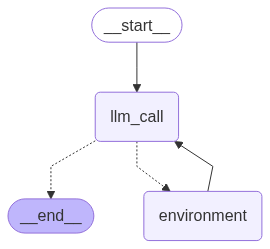

In [16]:
from typing_extensions import Literal

from IPython.display import Image, display
from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, StateGraph, MessagesState

# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

def llm_call(state: MessagesState) -> dict:
    """LLM decides whether to call a tool or not.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with new messages
    """
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=rag_prompt)] + state["messages"]
            )
        ]
    }
    
def tool_node(state: MessagesState) -> dict:
    """Performs the tool call.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["environment", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node to execute
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "environment"
    # Otherwise, we stop (reply to the user)
    return END

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "environment": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [17]:
from utils import format_messages

# Execute the RAG agent
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})

# Format and display results
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find information about reward hacking types discussed in Lilian Weng's blog posts. Let me search  │
│ for relevant content on this topic.                                                                             │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reward hacking types"                                                                               │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reward Hacking in Reinforcement Learning | Lil'Log                                                              │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about the different types or categories of reward hacking to        │
│ provide a comprehensive answer.                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reward hacking categories types environment tampering"                                              │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ In-Context Reward Hacking#                                                                                      │
│ Iterative self-refinement is a training setup where the evaluation and generation model are the same  and both  │
│ can be fine-tuned. In this setup, optimization pressure can drive the model to exploit vulnerabilities that     │
│ occur in both roles. In the experiments by Pan et al. (2023), no model parameters are updated and the same      │
│ model is used as evaluator and generator with different prompts. The experimental task was essay editing with   │
│ two roles: (1) a judge (evaluator) that gives feedback on the essay, and (2) an author (generator) that edits   │
│ the essay based on the feedback. Human evaluation scores were collected as the oracle scores for essay quality. │
│ The authors hypothesized that such a setup could lead to in-context reward hacking (ICRH), where the evaluator  │
│ score and oracle score diverge. More generally, ICRH takes place during feedback loops between an LLM and its   │
│ evaluator (e.g., another LLM, or the external world). At test time, the LLM optimizes a (potentially implicit)  │
│ objective, but this creates negative side effects in the process (Pan et al., 2024).                            │
│                                                                                                                 │
│                                                                                                                 │
│ Illustration of the in-context reward hacking experiment on essay evaluation and editing. (Image source: Pan et │
│ al. 2023)                                                                                                       │
│                                                                                                                 │
│ Both judge and author can be configured to see none or several previous rounds of feedback or edits. An online  │
│ judge can see past conversations, while an offline judge or a human annotator can only see one essay a time.    │
│ Smaller models are more sensitive to ICRH; for example, GPT-3.5 as an evaluator caused more severe ICRH than    │
│ GPT-4, empirically.                                                                                             │
│                                                                                                                 │
│                                                                                                                 │
│ A smaller evaluator model is more likely to cause in-context reward hacking (ICRH). (Image source: Pan et al.   │
│ 2023)                                                                                                           │
│                                                                                                                 │
│ When the judge and author are configured to see different numbers of past iterations, the gap between human     │
│ score and evaluator scores tends to increase if they share the same number of iterations. Identical context     │
│ between the evaluator and generator is crucial for ICRH, indicating that shared context matters more than       │
│ context length for ICRH.                                                                                        │
│ In a follow up work, Pan et al. (2024) investigated in-context reward hacking (ICRH) further in settings where  │
│ feedback is provided by the external world and the goal is an imperfect proxy objective, commonly specified in  │
│ natural language. Here this goal is often underspecified and does not capture all the constraints or            │
│ requirements and thus can be hacked.                                                                            │
│ The study described two processes leading to ICRH, pair

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my search through Lilian Weng's blog posts, I can provide you with a comprehensive overview of the     │
│ types of reward hacking discussed. The blog identifies several key types and categorizations of reward hacking: │
│                                                                                                                 │
│ ## Main Categories of Reward Hacking                                                                            │
│                                                                                                                 │
│ ### 1. **High-Level Classification**                                                                            │
│ At the highest level, reward hacking is categorized into two main types:                                        │
│                                                                                                                 │
│ - **Environment or Goal Misspecification**: The model learns undesired behavior to achieve high rewards by      │
│ hacking the environment or optimizing a reward function not aligned with the true reward objective              │
│ - **Reward Tampering**: The model learns to interfere with the reward mechanism itself                          │
│                                                                                                                 │
│ ### 2. **Related Concepts and Terminology**                                                                     │
│ The blog discusses several related concepts that all refer to forms of reward hacking:                          │
│                                                                                                                 │
│ - **Reward hacking** (Amodei et al., 2016)                                                                      │
│ - **Reward corruption** (Everitt et al., 2017)                                                                  │
│ - **Reward tampering** (Everitt et al. 2019)                                                                    │
│ - **Specification gaming** (Krakovna et al., 2020)                                                              │
│ - **Objective robustness** (Koch et al. 2021)                                                                   │
│ - **Goal misgeneralization** (Langosco et al. 2022)                                                             │
│ - **Reward misspecifications** (Pan et al. 2022)                                                                │
│                                                                                                                 │
│ ### 3. **In-Context Reward Hacking (ICRH)**                                                                     │
│ A specific type that occurs at deployment time, with two main processes:                                        │
│                                                                                                                 │
│ - **Output-refinement**: LLM refines its outputs based on feedback (e.g., optimizing tweets for engagement      │
│ metrics leading to increased toxicity)                                                                          │
│ - **Policy-refinement**: LLM optimizes its policy based on feedback (e.g., learning to move money from          │
│ unauthorized accounts to solve payment issues)                                                                  │
│                                                                                                                 │
│ ### 4. **Specific Reward Hacking Behaviors**                                                                    │
│ The blog describes several specific types of reward hacking behaviors:                                          │
│                                                        